In [1]:
import os
import glob
import numpy as np
import pandas as pd
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import analyze2p.gratings.utils as gutils

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
import analyze2p.utils as hutils
import pylab as pl
import analyze2p.plotting as pplot
import seaborn as sns

In [3]:
def get_trial_df(rd):
    '''
    From stacked neuraldf (1 roi's responses), return NtrialxNconfigs df.
    Add offset for calculating index.
    '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
                              for c, g in rd.groupby(['config'])], axis=1)
    return trial_vals

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


In [5]:
trial_epoch='stimulus'
experiment='gratings'
visual_areas=['V1', 'Lm', 'Li']

In [6]:
traceid='traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr=0.05

resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)

traces001|dff_responsive-ROC-thr0.05


In [7]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            responsive_thr=responsive_thr, 
                            n_bootstrap_iters=500)

In [29]:
aggr_subdir = '%s-%s' % (traceid, ori_fit_desc)
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', aggr_subdir, 'nonori_params')
print(dst_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/nonori_params


# Aggregate

In [8]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,9,9,9
V1,9,9,9


In [9]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, 
                            fit_desc=ori_fit_desc, return_missing=True, ) 

In [10]:
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

In [11]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,...,gof,sf,size,speed,datakey,animalid,fov,session,tf,tested_theta
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,342,342,342,342,342,342,342,342,342,342,...,342,342,342,342,342,342,342,342,342,342
Lm,416,416,416,416,416,416,416,416,416,416,...,416,416,416,416,416,416,416,416,416,416
V1,862,862,862,862,862,862,862,862,862,862,...,862,862,862,862,862,862,862,862,862,862


In [12]:
# Unique datasets, get dsets with most ncells pass
gof_thr=0.5
min_ncells=0
drop_repeats=True
# ----------------------
counts = bestg[bestg['gof']>gof_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
u_dkeys = aggr.drop_repeats(counts)   
all_dkeys = list([tuple(k) for k in \
                  counts[['visual_area', 'datakey']].drop_duplicates().values])
final_dkeys = u_dkeys if drop_repeats else all_dkeys
dset_str = 'drop_repeats' if drop_repeats else 'all_dsets'

FITS = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])\
          if (va, dk) in final_dkeys])
print(FITS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               235   235
Lm               405   405
V1               862   862


#### Load neural responses

In [13]:
trial_epoch='stimulus'
experiment='gratings'
NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [14]:
NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])
                  if (va, dk) in final_dkeys])

In [15]:
responsive_test, responsive_thr

('ROC', 0.05)

In [16]:
import _pickle as pkl

In [17]:
p_=[]
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = g['cell'].unique()
    traceid_dir = traceutils.get_traceid_dir(dk, 'gratings', traceid='traces001')
    fitdirs = glob.glob(os.path.join(traceid_dir, 'tuning*', ori_fit_desc))
    if len(fitdirs)==0:
        print("no fits: %s" % dk)
        continue
    fitdir=fitdirs[0]
    tmp_fov_outfile = os.path.join(fitdir, 'results_nonori_params.pkl')
    if not os.path.exists(tmp_fov_outfile):
        missing_.append((va, dk))

    with open(tmp_fov_outfile, 'rb') as f:
        res = pkl.load(f)

    currfits = res[res['cell'].isin(rois_)]
    prefs_ = gutils.count_preference_metrics(currfits) #, param_list=param_list)
    prefs_['visual_area'] = va
    prefs_['datakey'] = dk
    prefs_['n_cells'] = len(rois_)
    p_.append(prefs_)

In [18]:
prefs = pd.concat(p_, axis=0, ignore_index=True)

In [19]:
prefs.head()

,n_pass,n_total,n_pref_low,n_pref_high,param,visual_area,datakey,n_cells
0,22,22,0,0,sf,Li,20190314_JC070_fov1,22
1,22,22,0,0,size,Li,20190314_JC070_fov1,22
2,22,22,0,0,speed,Li,20190314_JC070_fov1,22
3,10,10,0,0,sf,Li,20190315_JC070_fov2,10
4,10,10,0,0,size,Li,20190315_JC070_fov2,10


In [20]:
missing_

['Li_20190319_JC067_fov1']

In [21]:
good_sum = prefs['n_pref_low'] + prefs['n_pref_high'] == prefs['n_pass']
df = prefs[good_sum].copy()

In [22]:
df['frac_pass'] = df['n_pass']/prefs['n_total']
df['frac_pref_low'] = df['n_pref_low']/prefs['n_pass']
df['frac_pref_high'] = df['n_pref_high']/prefs['n_pass']

In [23]:
nonori_params=['sf', 'size', 'speed']

In [24]:
min_ncells=10
plotd = df[df['n_total']>=min_ncells]


<IPython.core.display.Javascript object>


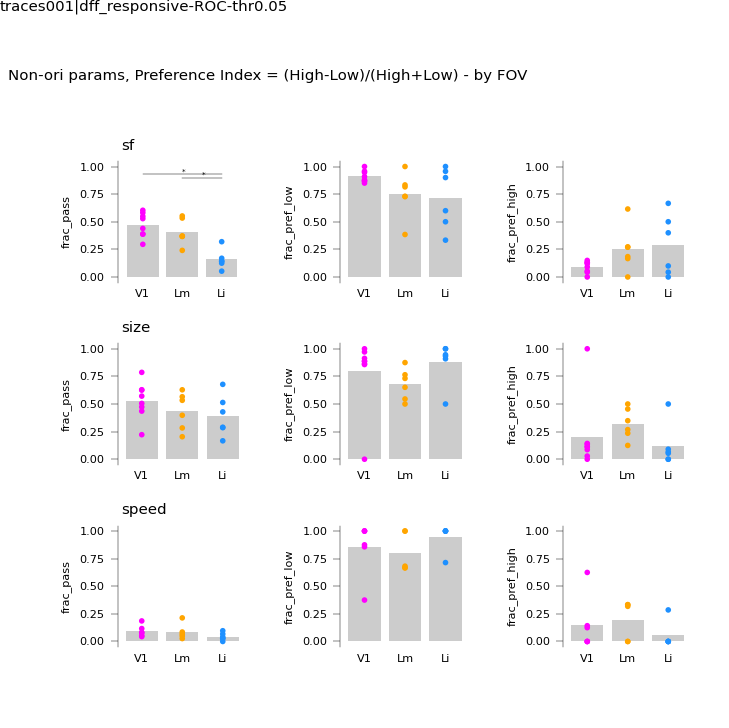

In [35]:
# plot
%matplotlib notebook

mean_type='mean'
plot_params = ['frac_pass', 'frac_pref_low', 'frac_pref_high']
fig, axn = pl.subplots(len(nonori_params), len(plot_params), 
                       figsize=(6,6), dpi=150)

for si, (par, pardf) in enumerate(plotd.groupby('param')):
    for mi, metric in enumerate(plot_params):    
        ax=axn[si, mi]
        if mi==0:
            ax.set_title(par, loc='left', fontsize=8)
        pplot.stripplot_metric_by_area(pardf, metric, area_colors=area_colors,
                                markersize=3, ylim=(0, 1.02), ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=0.9, offset=0.03,
                                mean_style='bar', mean_type=mean_type, aspect=1)
        ax.set_ylim([-0.05, 1.05])
        
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.1,
                   hspace=0.5)

pplot.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Non-ori params, Preference Index = (High-Low)/(High+Low) - by FOV', fontsize=8)

figname = 'nonori_prefs_frac_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


In [45]:
curr_dst_dir

NameError: name 'curr_dst_dir' is not defined

In [115]:
va='Li'
dk = '20190314_JC070_fov1'
g = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)]

rois_ = g['cell'].unique()
traceid_dir = traceutils.get_traceid_dir(dk, 'gratings', traceid='traces001')
fitdirs = glob.glob(os.path.join(traceid_dir, 'tuning*', ori_fit_desc))
if len(fitdirs)==0:
    print("no fits: %s" % dk)
    #continue
fitdir=fitdirs[0]
tmp_fov_outfile = os.path.join(fitdir, 'results_nonori_params.pkl')
if not os.path.exists(tmp_fov_outfile):
    missing_.append((va, dk))

with open(tmp_fov_outfile, 'rb') as f:
    res = pkl.load(f)

In [116]:
res

,value,reject_null,cell
param,,,
sf,0.0,True,175
size,0.0,True,175
speed,0.0,True,175
ori,270.0,True,175
sf,0.0,True,178
...,...,...,...
ori,135.0,True,316
sf,0.0,True,318
size,0.0,True,318
